## Imports

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rc('font', family='Georgia')

from generalist_optimization import ENEMY_SETS, NGEN

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
CMAES_DATAPATH = os.path.join('data', 'cmaes')
NEAT_DATAPATH = os.path.join('data', 'neat')

In [44]:
ENEMY_SET_1 = ENEMY_SETS['set_1']
ENEMY_SET_2 = ENEMY_SETS['set_2']

In [45]:
FIGURE_PATH = os.path.join('figures', 'generalist')
os.makedirs(FIGURE_PATH, exist_ok=True)

## Figure 1: Fitness comparison

The figure below presents a comparison of fitness of generalist agents trained with two evolutionary algorithms: CMAES and NEAT across all generations.

In [63]:
cmaes_data = np.array([
    np.load(os.path.join(CMAES_DATAPATH, "set_1", "hp_crit_mean_of_max", "train_all_fitnesses.npy")),
    np.load(os.path.join(CMAES_DATAPATH, "set_2", "hp_crit_mean_of_max", "train_all_fitnesses.npy"))
])

print(cmaes_data.shape)

(2, 5, 100, 10)


In [64]:
# Max fitness among individuals
cmaes_max = np.max(cmaes_data, axis=3)
print(cmaes_max.shape)

# Hall-of-fame variant instead of generational max
cmaes_hof = np.maximum.accumulate(cmaes_max, axis=2)
print(cmaes_hof.shape)

# Mean fitness among individuals
cmaes_mean = np.mean(cmaes_data, axis=3)
print(cmaes_mean.shape)

(2, 5, 100)
(2, 5, 100)
(2, 5, 100)


In [90]:
def plot_mean_with_sd(ax, xx, means, sds, color="blue", fill_color="lightblue", linestyle="solid", label=""):
    """
    Helper function for plotting mean values with standard deviations
    """
    line = ax.plot(xx, means, color=color, linestyle=linestyle, lw=1.8)
    ax.fill_between(xx, means + sds, means - sds, color=fill_color, alpha=0.6, edgecolor=color, linewidth=0.0)

    return line[0]

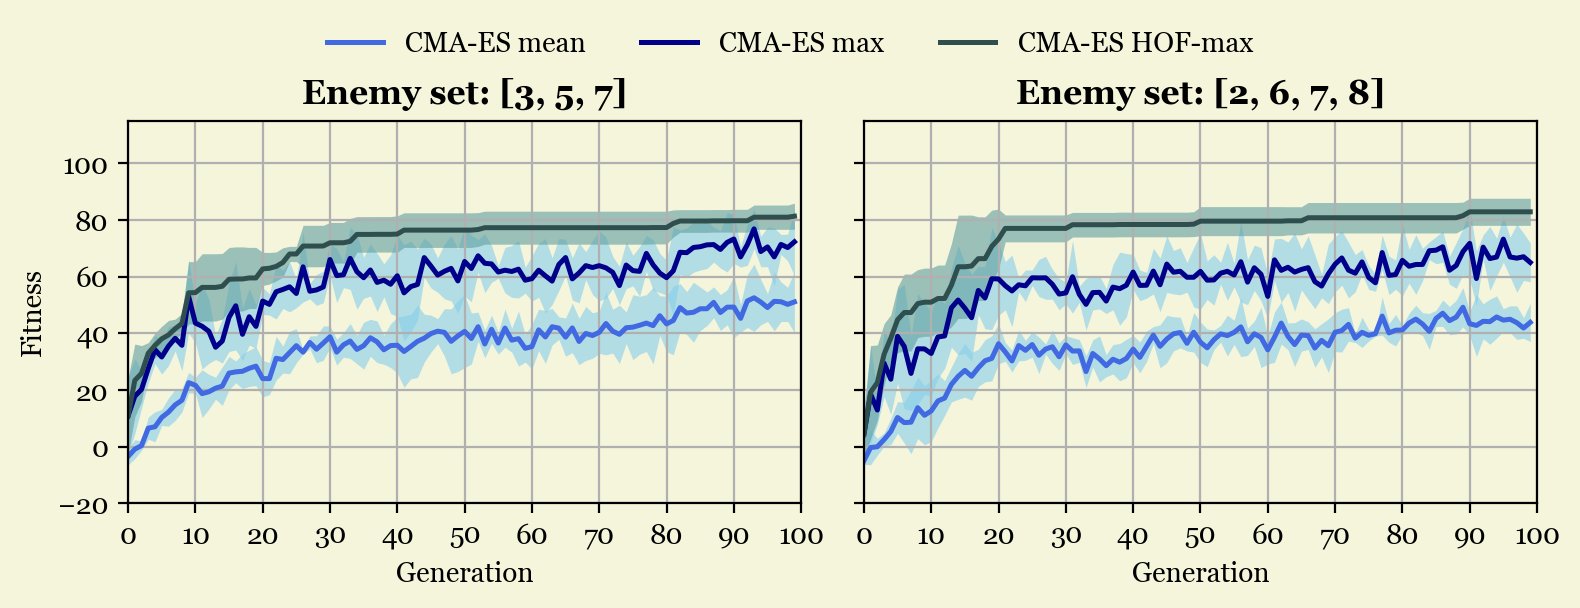

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=200, sharey=True)
fig.patch.set_facecolor('beige')

# Plot formatting
for (i, enemy_set) in enumerate([ENEMY_SET_1, ENEMY_SET_2]):
    axes[i].set_ylim(-20, 115)
    axes[i].set_yticks(np.arange(-20, 101, 20))

    axes[i].set_facecolor('beige')

    if i == 0:
        axes[i].set_ylabel("Fitness")
        
    axes[i].set_xlim(0, NGEN)
    axes[i].set_xticks(np.arange(0, NGEN + 1, 10))
    axes[i].set_xlabel("Generation")
    axes[i].set_title(f"Enemy set: {enemy_set}", weight="bold")
    axes[i].grid()

lines = []
labels = []
for i in range(2):
    # line1 = axes[i].errorbar(range(NGEN), neat_avg_mean[i], yerr=neat_sd_mean[i], alpha=0.6, lw=1.2, color="red", label="NEAT mean")
    # line2 = axes[i].errorbar(range(NGEN), neat_avg_max[i], yerr=neat_sd_max[i], alpha=0.6, lw=1.2, color="darkred", label="NEAT max")
    # line3 = axes[i].errorbar(range(NGEN), np.mean(cmaes_mean[i], axis=0), yerr=np.std(cmaes_mean[i], axis=0), alpha=0.6, lw=1.2, color="royalblue", label="CMAES mean")
    # line4 = axes[i].errorbar(range(NGEN), np.mean(cmaes_max[i], axis=0), yerr=np.std(cmaes_max[i], axis=0), alpha=0.6, lw=1.2, color="darkblue", label="CMAES max")
    # line5 = axes[i].errorbar(range(NGEN), np.mean(cmaes_hof[i], axis=0), yerr=np.std(cmaes_hof[i], axis=0), alpha=0.6, lw=1.2, color="green", label="CMAES HOF-max")

    line3 = plot_mean_with_sd(axes[i], range(NGEN), np.mean(cmaes_mean[i], axis=0), np.std(cmaes_mean[i], axis=0), color="royalblue", fill_color="skyblue", label="CMAES-mean")
    line4 = plot_mean_with_sd(axes[i], range(NGEN), np.mean(cmaes_max[i], axis=0), np.std(cmaes_max[i], axis=0), color="darkblue", fill_color="skyblue", label="CMAES-max")
    line5 = plot_mean_with_sd(axes[i], range(NGEN), np.mean(cmaes_hof[i], axis=0), np.std(cmaes_hof[i], axis=0), color="darkslategray", fill_color="cadetblue", label="CMAES HOF-max")

    if i == 0:
        # lines.extend([line1, line2, line3, line4, line5])
        # labels.extend(["NEAT mean", "NEAT max", "CMA-ES mean", "CMA-ES max", "CMA-ES HOF-max"])

        lines.extend([line3, line4, line5])
        labels.extend(["CMA-ES mean", "CMA-ES max", "CMA-ES HOF-max"])

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(lines, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.02), fontsize=10, frameon=False)
# fig.savefig("figures/convergence.png", dpi=400)
plt.show()

In [60]:
np.maximum.accumulate([1,2,3,4,5,4,3,2,1])

array([1, 2, 3, 4, 5, 5, 5, 5, 5])

Clear cached variables

In [29]:
%reset -f

In [30]:
print(DATA_PATH_1)

NameError: name 'DATA_PATH_1' is not defined